# 🧠 Práctica final NLP

## 📊 Análisis de Sentimiento - Descarga y exploración del corpus

### 🛒 Dataset: Reviews de Amazon

Este dataset contiene reseñas de productos de Amazon clasificadas por categorías, en este caso, **Deportes y actividades al aire libre**.  
Cada reseña incluye una calificación representada por un **número de estrellas ⭐**.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from wordcloud import WordCloud
import json
import gzip
import re
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Cargar modelo SpaCy
nlp = spacy.load("en_core_web_sm")

# Descargar y balancear el dataset
# URL del dataset
dataset_url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz'

# Rutas locales para guardar archivos comprimidos y descomprimidos
compressed_path = '/content/reviews_Sports_and_Outdoors_5.json.gz'
decompressed_path = '/content/reviews_Sports_and_Outdoors_5.json'

# Descargar el archivo
print("Descargando dataset...")
!wget -O {compressed_path} {dataset_url}
print("Descarga completada.")

# Descomprimir el archivo
print("Descomprimiendo archivo...")
with gzip.open(compressed_path, 'rb') as f_in:
    with open(decompressed_path, 'wb') as f_out:
        f_out.write(f_in.read())
print("Archivo descomprimido exitosamente.")

Descargando dataset...
--2025-05-03 18:33:35--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68275834 (65M) [application/x-gzip]
Saving to: ‘/content/reviews_Sports_and_Outdoors_5.json.gz’

/content/reviews_Sp 100%[===================>]  65.11M  54.4MB/s    in 1.2s    

2025-05-03 18:33:36 (54.4 MB/s) - ‘/content/reviews_Sports_and_Outdoors_5.json.gz’ saved [68275834/68275834]

Descarga completada.
Descomprimiendo archivo...
Archivo descomprimido exitosamente.


In [ ]:
# Crear un dataset balanceado
# Número de registros positivos y negativos deseados
max_records = 5000

positive_records = []
negative_records = []

print("Procesando archivo JSON para crear dataset balanceado...")
with open(decompressed_path, 'r') as file:
    for line in file:
        # Leer cada línea como un diccionario
        record = json.loads(line)
        rating = record.get('overall')  # Obtener calificación (1 a 5)
        if rating is not None:
            # Clasificar como positivo o negativo según la calificación
            if rating >= 4 and len(positive_records) < max_records:
                positive_records.append(record)
            elif rating <= 3 and len(negative_records) < max_records:
                negative_records.append(record)
        # Salir del bucle si se alcanzan los límites
        if len(positive_records) >= max_records and len(negative_records) >= max_records:
            break

# Combinar listas en un DataFrame
df_positive = pd.DataFrame(positive_records)
df_negative = pd.DataFrame(negative_records)

# Añadir columna de sentimiento
df_positive['sentiment'] = 'positive'
df_negative['sentiment'] = 'negative'

reviews_df = pd.concat([df_positive, df_negative]).reset_index(drop=True)

print(f"Dataset balanceado creado con {len(df_positive)} positivos y {len(df_negative)} negativos.")

# Guardar DataFrame balanceado
reviews_df.to_csv('/content/balanced_dataset.csv', index=False)
print("Dataset balanceado guardado en 'balanced_dataset.csv'")

Procesando archivo JSON para crear dataset balanceado...
Dataset balanceado creado con 5000 positivos y 5000 negativos.


# 1. Cardinalidad del vocabulario

In [ ]:
print("\n1. CARDINALIDAD DEL VOCABULARIO")
print("="*50)
all_words = []
for review in reviews_df['reviewText']:
    if isinstance(review, str):
        doc = nlp(review.lower())
        tokens = [token.text for token in doc]
        all_words.extend(tokens)

vocabulary = set(all_words)
print(f"Cardinalidad del vocabulario: {len(vocabulary)} palabras únicas")


1. CARDINALIDAD DEL VOCABULARIO
Cardinalidad del vocabulario: 30421 palabras únicas


# 2. Distribución de reviews por número de estrellas


2. DISTRIBUCIÓN DE REVIEWS POR NÚMERO DE ESTRELLAS


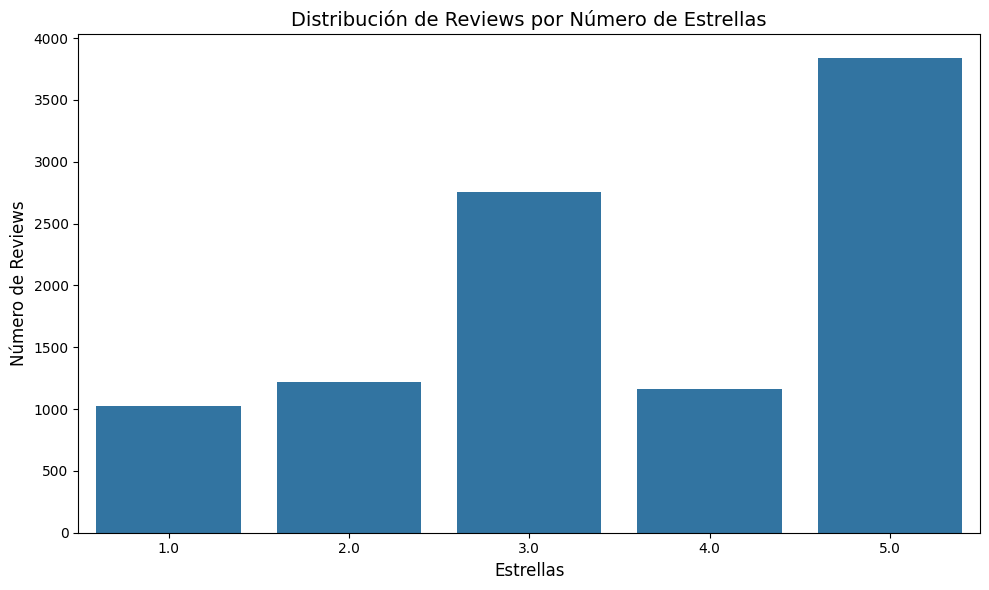

overall
1.0    1024
2.0    1218
3.0    2758
4.0    1162
5.0    3838
Name: count, dtype: int64


In [ ]:
print("\n2. DISTRIBUCIÓN DE REVIEWS POR NÚMERO DE ESTRELLAS")
print("="*50)
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', data=reviews_df, order=sorted(reviews_df['overall'].unique()))
plt.title('Distribución de Reviews por Número de Estrellas', fontsize=14)
plt.xlabel('Estrellas', fontsize=12)
plt.ylabel('Número de Reviews', fontsize=12)
plt.tight_layout()
plt.savefig('stars_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(reviews_df['overall'].value_counts().sort_index())

# 3. Número de reviews positivas y negativas


3. NÚMERO DE REVIEWS POSITIVAS Y NEGATIVAS
sentiment
positive    5000
negative    5000
Name: count, dtype: int64


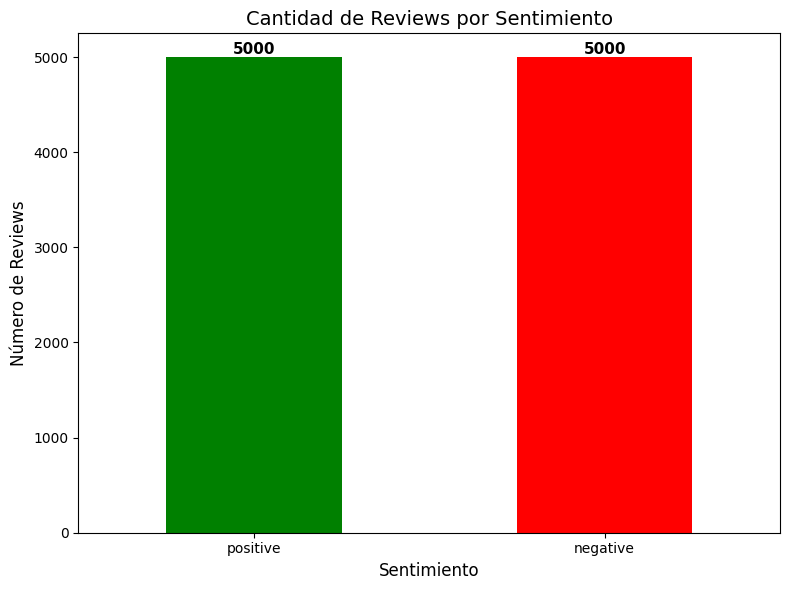

In [ ]:
print("\n3. NÚMERO DE REVIEWS POSITIVAS Y NEGATIVAS")
print("="*50)
sentiment_counts = reviews_df['sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 6))
colors = {'negative': 'red', 'positive': 'green'}
bar_colors = [colors[sentiment] for sentiment in sentiment_counts.index]
bars = sentiment_counts.plot(kind='bar', color=bar_colors)
plt.title('Cantidad de Reviews por Sentimiento', fontsize=14)
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Número de Reviews', fontsize=12)
plt.xticks(rotation=0)

# Añadir valores sobre las barras
for bar in bars.patches:
    height = bar.get_height()
    ax = bar.axes
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(height)}',
           ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. N-gramas más frecuentes


4. N-GRAMAS MÁS FRECUENTES

Top 20 unigrams:
use: 3631
good: 3046
like: 3022
great: 2433
knife: 1898
product: 1715
time: 1662
little: 1610
work: 1554
better: 1521
bought: 1488
quality: 1353
price: 1317
works: 1272
fit: 1237
easy: 1231
need: 1204
small: 1198
buy: 1189
way: 1127

Top 20 bigrams:
works great: 262
good quality: 186
easy use: 181
highly recommend: 162
year old: 156
swiss army: 142
great product: 130
long time: 127
high quality: 126
years ago: 126
looks like: 119
speed loader: 109
work great: 103
feel like: 98
speed loaders: 98
good product: 97
bore snake: 97
recommend product: 94
light weight: 93
great price: 90


<ipython-input-24-ad3a28741331>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=unigrams_df, palette='viridis')
<ipython-input-24-ad3a28741331>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Bigram', data=bigrams_df, palette='viridis')


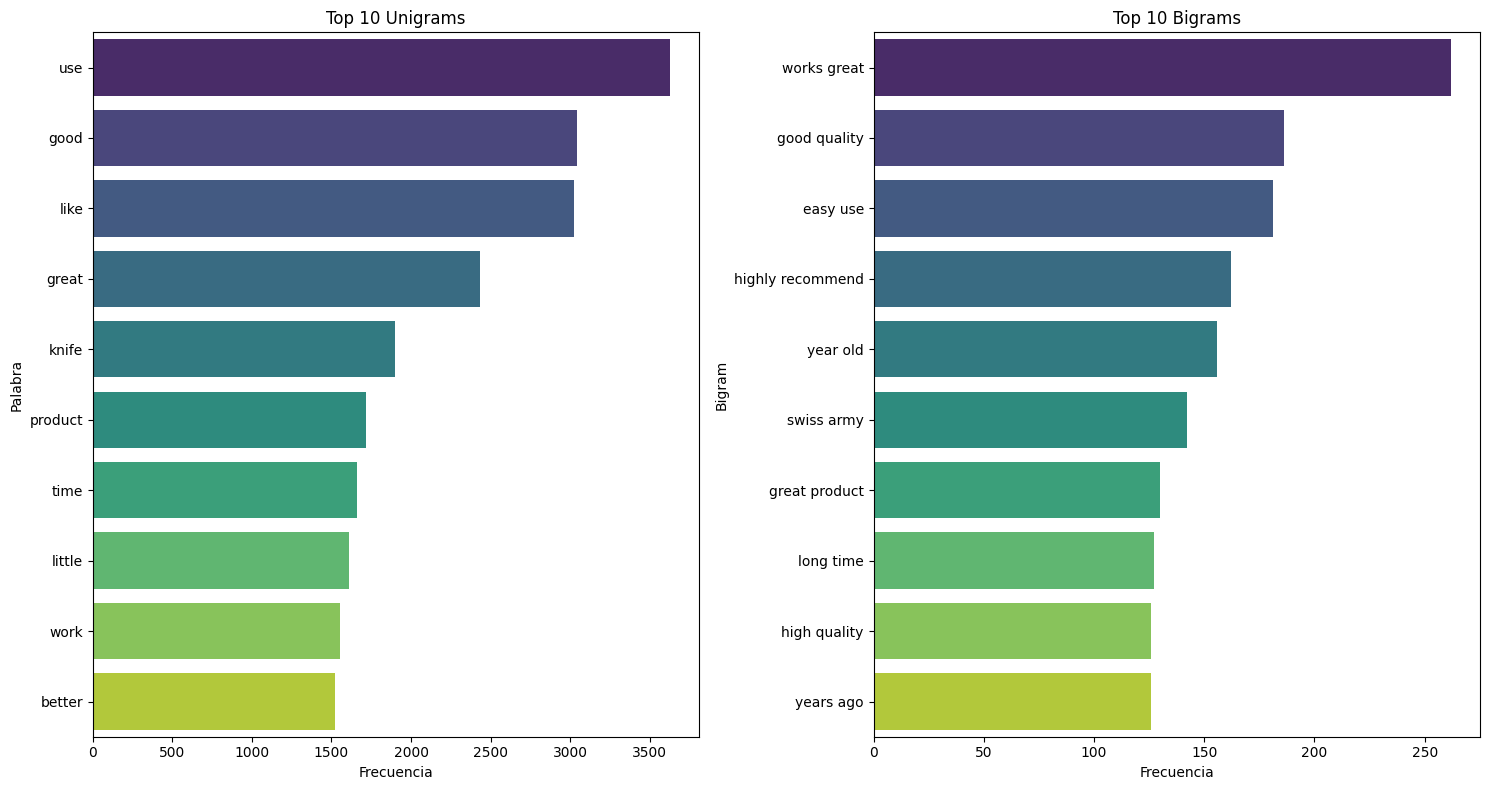

In [ ]:
print("\n4. N-GRAMAS MÁS FRECUENTES")
print("="*50)

def get_ngrams_spacy(text, n):
    if not isinstance(text, str):
        return []
    doc = nlp(text.lower())
    # Filtrar stopwords y puntuación
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]

    # Crear n-gramas
    n_grams = []
    for i in range(len(tokens) - n + 1):
        n_grams.append(' '.join(tokens[i:i+n]))

    return n_grams

# Unigramas
all_unigrams = []
for review in reviews_df['reviewText']:
    all_unigrams.extend(get_ngrams_spacy(review, 1))

unigram_frequency = Counter(all_unigrams).most_common(20)
print("\nTop 20 unigrams:")
for word, freq in unigram_frequency:
    print(f"{word}: {freq}")

# Bigramas
all_bigrams = []
for review in reviews_df['reviewText']:
    all_bigrams.extend(get_ngrams_spacy(review, 2))

bigram_frequency = Counter(all_bigrams).most_common(20)
print("\nTop 20 bigrams:")
for bigram, freq in bigram_frequency:
    print(f"{bigram}: {freq}")

# Visualizar n-gramas
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
unigrams_df = pd.DataFrame(unigram_frequency[:10], columns=['Palabra', 'Frecuencia'])
sns.barplot(x='Frecuencia', y='Palabra', data=unigrams_df, palette='viridis')
plt.title('Top 10 Unigrams')

plt.subplot(1, 2, 2)
bigrams_df = pd.DataFrame(bigram_frequency[:10], columns=['Bigram', 'Frecuencia'])
sns.barplot(x='Frecuencia', y='Bigram', data=bigrams_df, palette='viridis')
plt.title('Top 10 Bigrams')
plt.tight_layout()
plt.show()

# 5. Nubes de palabras


5. NUBES DE PALABRAS


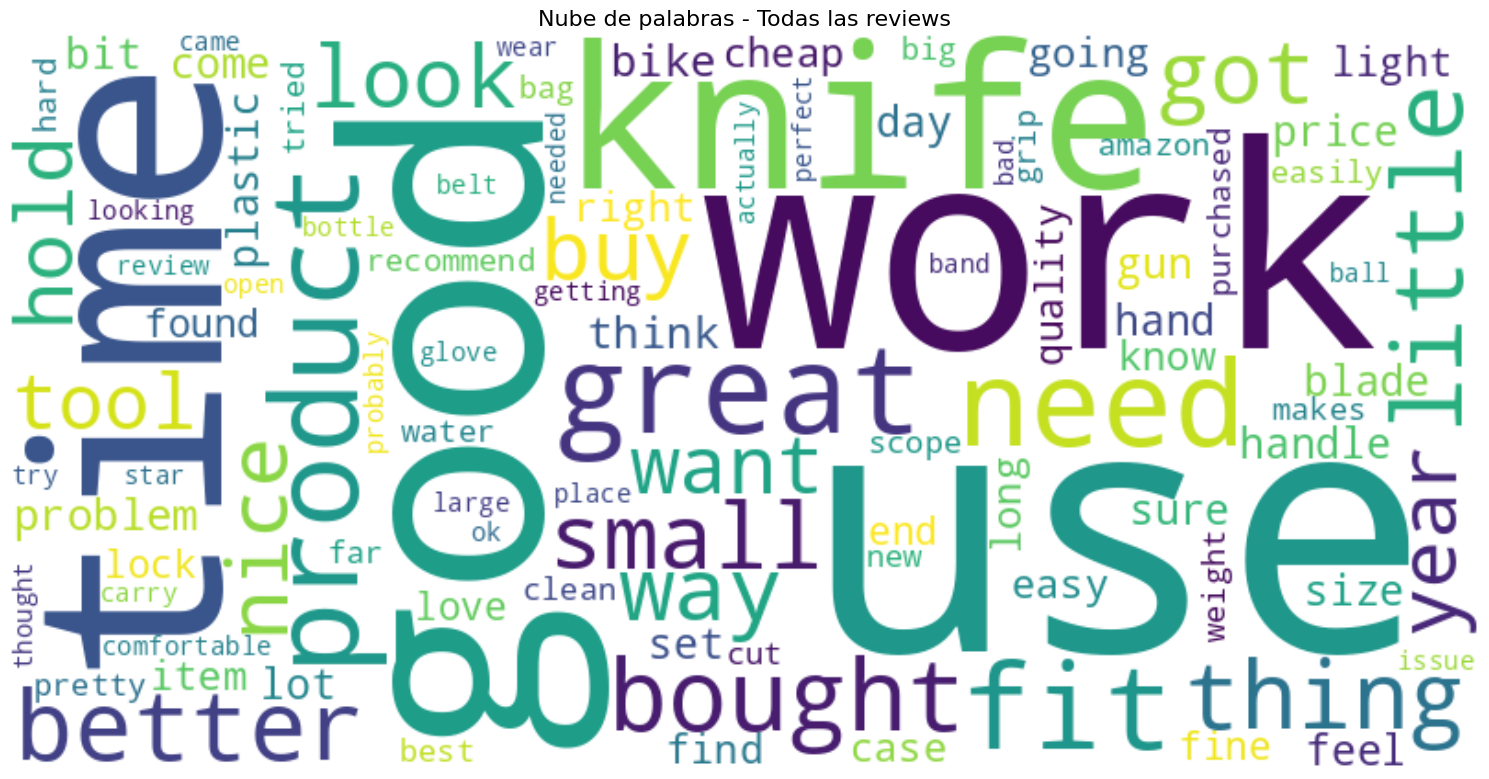

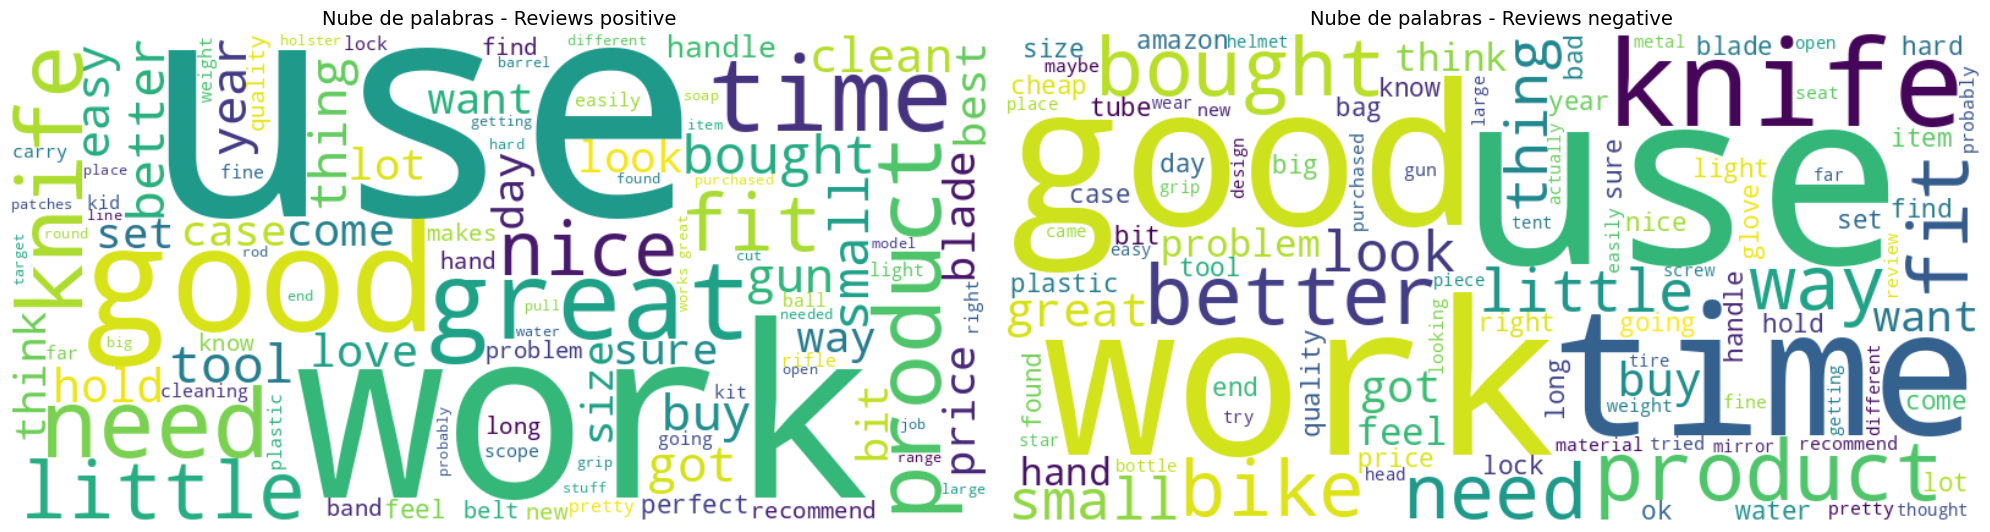

In [ ]:
print("\n5. NUBES DE PALABRAS")
print("="*50)

# Preprocesar texto para nubes de palabras
def preprocess_text_for_wordcloud(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text.lower())
    # Filtrar stopwords y puntuación
    words = [token.text for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return ' '.join(words)

# Para todas las reviews
all_text = ' '.join(reviews_df['reviewText'].apply(preprocess_text_for_wordcloud))
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Todas las reviews', fontsize=16)
plt.tight_layout()
plt.savefig('wordcloud_all.png', dpi=300, bbox_inches='tight')
plt.show()

# Por sentimiento
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, sentiment in enumerate(['positive', 'negative']):
    if sentiment in reviews_df['sentiment'].unique():
        text = ' '.join(reviews_df[reviews_df['sentiment'] == sentiment]['reviewText'].apply(preprocess_text_for_wordcloud))
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'Nube de palabras - Reviews {sentiment}', fontsize=14)

plt.tight_layout()
plt.show()

# 6. Visualización de word embeddings usando TF-IDF


6. VISUALIZACIÓN DE WORD EMBEDDINGS

Palabras encontradas en vocabulario:
- good
- bad
- excellent
- love
- quality
- product

Palabras similares a 'good':
  - quality: 0.143
  - price: 0.134
  - value: 0.082
  - deal: 0.066
  - pretty: 0.057

Palabras similares a 'bad':
  - poor: 0.052
  - reviews: 0.050
  - wire: 0.049
  - bucks: 0.049
  - suppose: 0.045

Palabras similares a 'excellent':
  - value: 0.104
  - product: 0.065
  - sog: 0.055
  - mechanism: 0.047
  - choice: 0.045

Palabras similares a 'love':
  - soap: 0.106
  - kids: 0.096
  - absolutely: 0.073
  - pan: 0.060
  - live: 0.056

Palabras similares a 'quality':
  - high: 0.167
  - good: 0.143
  - poor: 0.117
  - price: 0.109
  - build: 0.099

Palabras similares a 'product':
  - description: 0.096
  - recommend: 0.096
  - great: 0.088
  - excellent: 0.065
  - price: 0.059


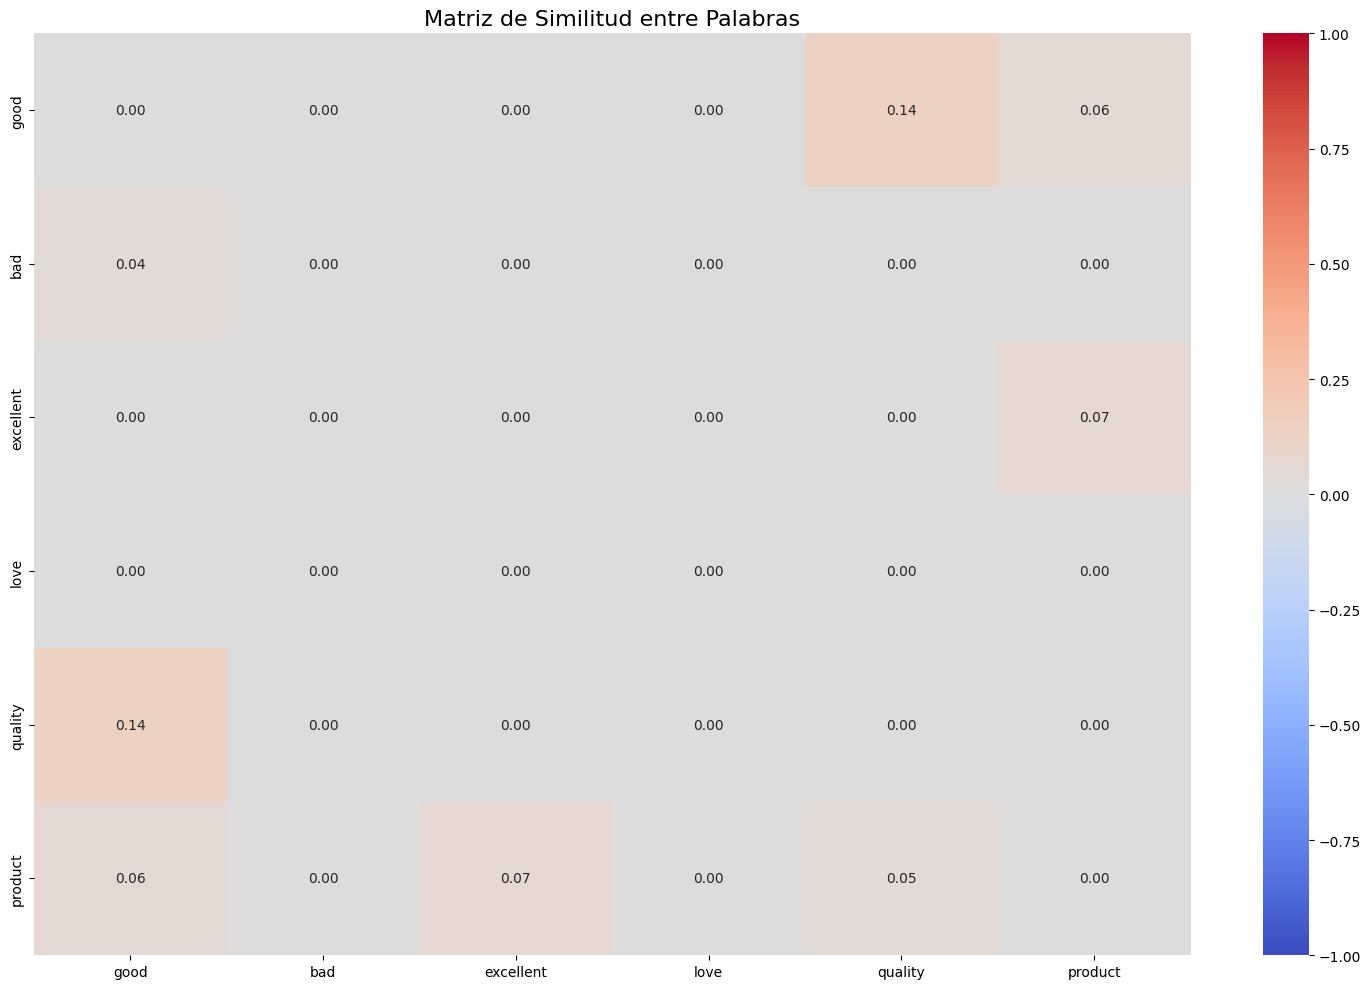

In [ ]:
print("\n6. VISUALIZACIÓN DE WORD EMBEDDINGS")
print("="*50)

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 1)
)

# Procesar textos
processed_reviews = reviews_df['reviewText'].apply(preprocess_text_for_wordcloud)

# Ajustar el vectorizador
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_reviews)

# Obtener vocabulario
feature_names = tfidf_vectorizer.get_feature_names_out()

# Seleccionar palabras para visualización
target_words = ['good', 'bad', 'excellent', 'terrible', 'love', 'quality', 'product']
words_to_plot = []

print("\nPalabras encontradas en vocabulario:")
for word in target_words:
    if word in feature_names:
        words_to_plot.append(word)
        print(f"- {word}")

# Obtener vectores TF-IDF para estas palabras
word_indices = [list(feature_names).index(word) for word in words_to_plot]
vectors = tfidf_matrix[:, word_indices].toarray()

# Encontrar palabras similares usando correlación
similarities = []
for i, target_idx in enumerate(word_indices):
    target_vector = tfidf_matrix[:, target_idx].toarray().flatten()

    # Calcular correlación con todas las palabras
    correlations = []
    for j in range(len(feature_names)):
        if j != target_idx:
            other_vector = tfidf_matrix[:, j].toarray().flatten()
            # Calcular correlación
            correlation = np.corrcoef(target_vector, other_vector)[0,1]
            if not np.isnan(correlation):
                correlations.append((feature_names[j], correlation))

    # Ordenar por correlación y obtener top 10
    correlations.sort(key=lambda x: x[1], reverse=True)
    similar_words = correlations[:10]
    similarities.append((words_to_plot[i], similar_words))

    print(f"\nPalabras similares a '{words_to_plot[i]}':")
    for word, corr in similar_words[:5]:
        print(f"  - {word}: {corr:.3f}")

# Visualización simplificada
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Crear una matriz de similitud
similarity_matrix = np.zeros((len(words_to_plot), len(words_to_plot)))
for i, (word1, _) in enumerate(similarities):
    for j, (word2, _) in enumerate(similarities):
        if i != j:
            # Buscar similitud entre word1 y word2
            for similar_word, corr in similarities[i][1]:
                if similar_word == word2:
                    similarity_matrix[i, j] = corr
                    break

# Crear un heatmap de similitudes
sns.heatmap(similarity_matrix,
            xticklabels=words_to_plot,
            yticklabels=words_to_plot,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)

plt.title('Matriz de Similitud entre Palabras', fontsize=16)
plt.tight_layout()
plt.show()

# 7. CONCLUSIONES DE LA EXPLORACIÓN

- Dataset balanceado con 10000 reviews
- Vocabulario único: 30421 palabras
- Distribución equilibrada: 5000 positivas y 5000 negativas
- Las palabras más frecuentes reflejan principalmente calidad del producto y experiencia de uso



In [ ]:
# Descargar archivos generados
from google.colab import files
files.download('/content/balanced_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>